<a href="https://colab.research.google.com/github/lorenzopaolucci/prova/blob/Lorenzo/sono_PIENA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GENERAZIONE GRIGLIA**


In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

L = 50                        # Dimensione griglia
centers = [[L*0.5-1,L*0.5-1]] # Centro del blob
n_samples = 3000              # Numero di segnali generati
sigma_noise = 2               # Sigma del rumore
sigma_spatial = 4             # Sigma della distribuzione spaziale del blob (in pixel)

min_eps = 4
max_eps = 8
step_eps = 0.5

th = 1.5*sigma_noise

# Genero le griglie

grid = np.zeros((L,L))        # Contiene le "coordinate" di ogni pixel, e il valore del segnale
background = np.zeros((L,L))  # Griglia background
signal = np.zeros((L,L))      # Griglia segnale

# Genero il fondo

for i in np.arange(0,L,1):    

  for j in np.arange(0,L,1):

    r = np.random.normal(0,2)
    background[i][j] = r

# Genero il blob

X, blob_labels = make_blobs(n_samples=n_samples, centers=centers, cluster_std=sigma_spatial, random_state=0)

# Discretizzazione del blob

for j in np.arange(0,len(X),1):

  x = int(np.round(X[j][0]))
  y = int(np.round(X[j][1]))

  signal[x][y] += 1

# Somma background+segnale

count=0
tot_noise = 0

for j in np.arange(0,L,1):

  for i in np.arange(0,L,1):

    s = signal[i][j] + background[i][j]

    if s >= th:

      grid[i][j] = np.round(s)
      count += 1

    if signal[i][j] == 0 and background[i][j] >= th:

      background[i][j] = np.round(background[i][j])
      tot_noise += 1

    else:

      background[i][j] = 0

    if s >= th and signal[i][j] != 0:

      signal[i][j] = np.round(s)

    else:

      signal[i][j] = 0

tot_signal = count - tot_noise

# Creazione array coordinate per DBSCAN

points_list = []
signal_list = []
background_list= []
 
for i in np.arange(0,L,1):

  for j in np.arange(0,L,1):

    if grid[i][j] != 0:

      points_list.append([j,i,grid[i][j]])

    if signal[i][j] != 0:
      signal_list.append([j,i,signal[i][j]])

    if background[i][j] != 0:
      background_list.append([j,i,background[i][j]])

points = np.array(points_list)
signal_plot = np.array(signal_list)
background_plot = np.array(background_list)

**PLOT GRIGLIA E ISTOGRAMMI**

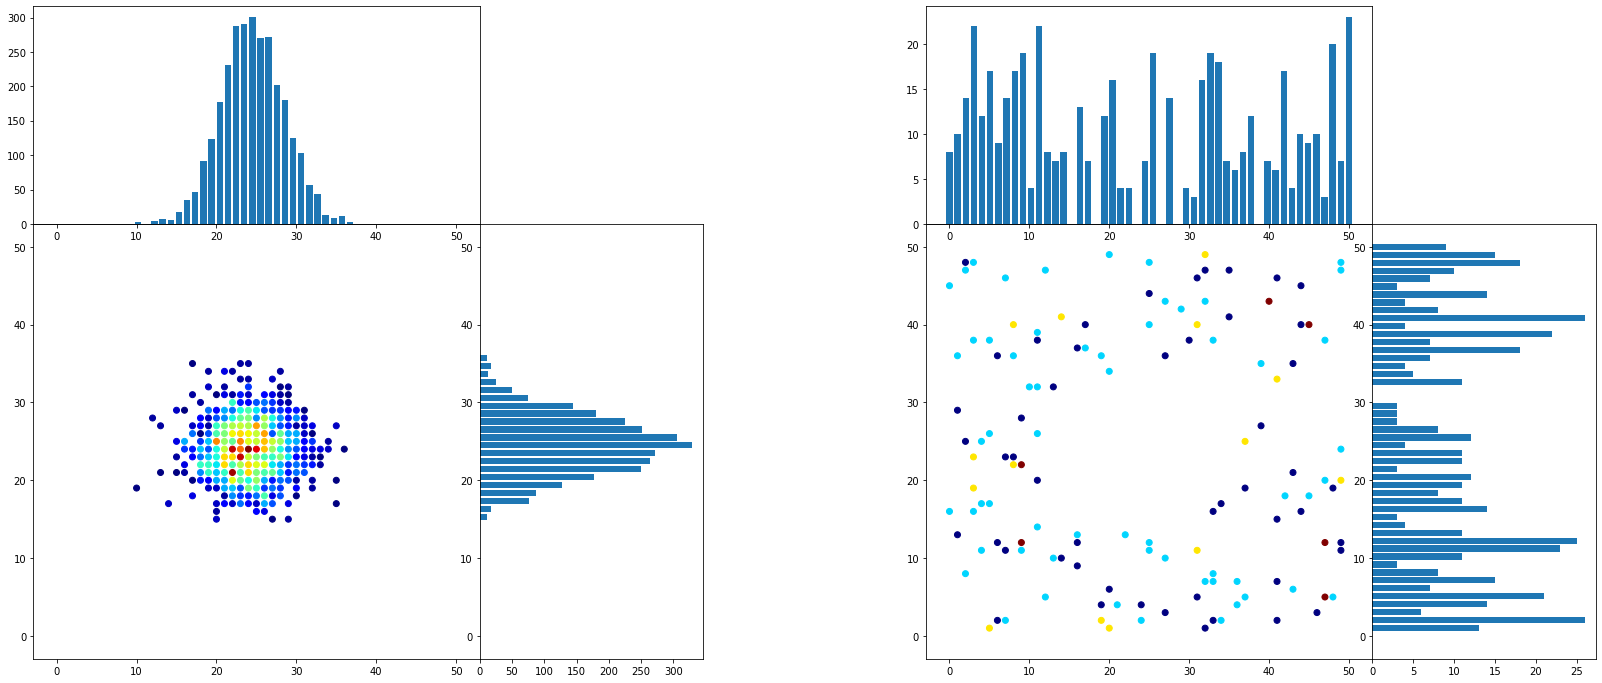

In [119]:
# Istogramma segnale

hist_x = np.apply_along_axis(sum,0,signal)
hist_y = np.apply_along_axis(sum,1,signal)
x = np.linspace(0,L,L)

fig = plt.figure(figsize=(28,12))
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

ax1 = plt.subplot2grid((3,7),(1,0),rowspan=2,colspan=2)
ax1.scatter(signal_plot[:,0],signal_plot[:,1],c=signal_plot[:,2],cmap='jet')

ax2 = plt.subplot2grid((3,7),(1,2),colspan=1,rowspan=2,sharey=ax1)
ax2.barh(x,hist_y)

ax3 = plt.subplot2grid((3,7),(0,0),colspan=2,rowspan=1,sharex=ax1)
ax3.bar(x,hist_x)
 
# Istogramma rumore 

hist_x = np.apply_along_axis(sum,0,background)
hist_y = np.apply_along_axis(sum,1,background)
x = np.linspace(0,L,L)

ax4 = plt.subplot2grid((3,7),(1,4),rowspan=2,colspan=2)
ax4.scatter(background_plot[:,0],background_plot[:,1],c=background_plot[:,2],cmap='jet')

ax5 = plt.subplot2grid((3,7),(1,6),colspan=1,rowspan=2,sharey=ax4)
ax5.barh(x,hist_y)

ax6 = plt.subplot2grid((3,7),(0,4),colspan=2,rowspan=1,sharex=ax4)
ax6.bar(x,hist_x)

plt.show()



**DBSCAN**

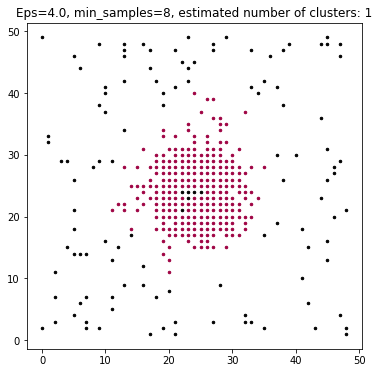

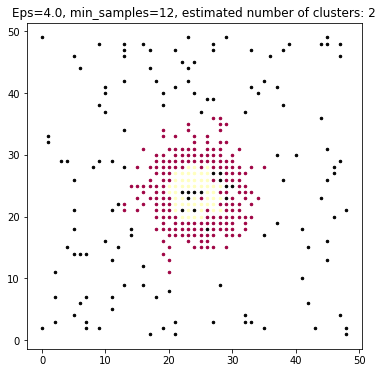

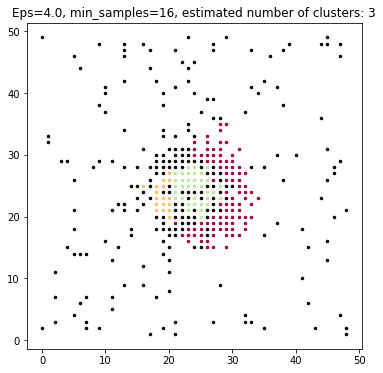

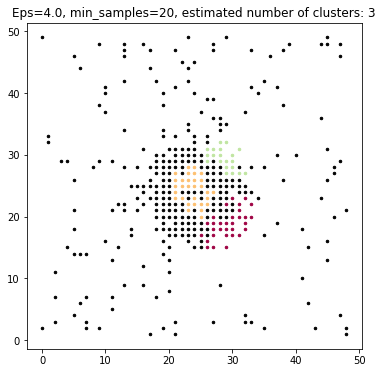

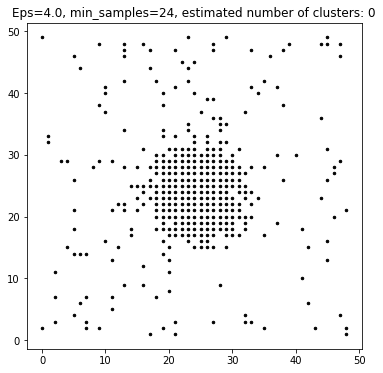

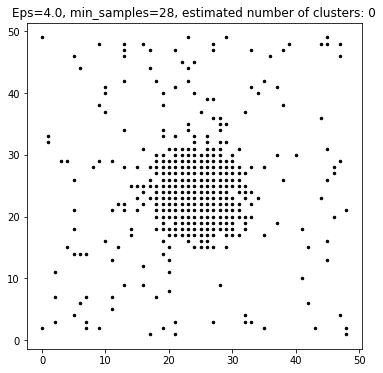

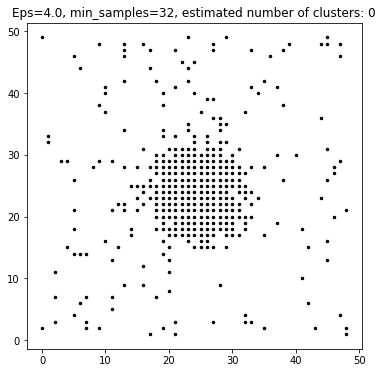

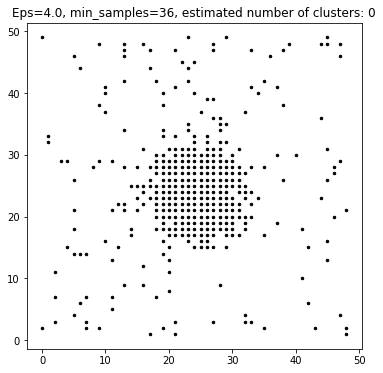

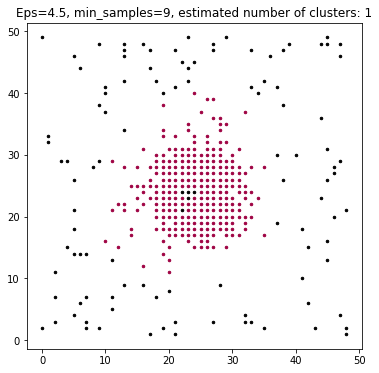

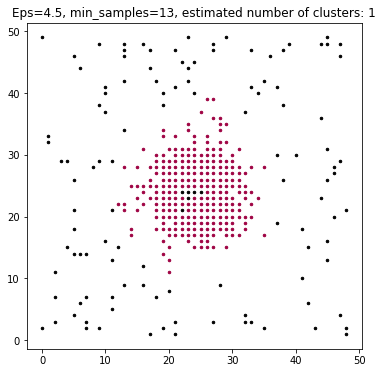

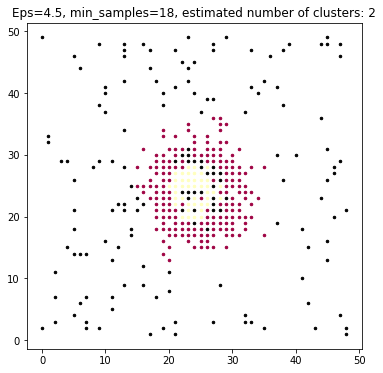

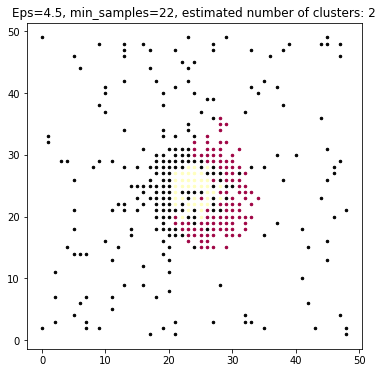

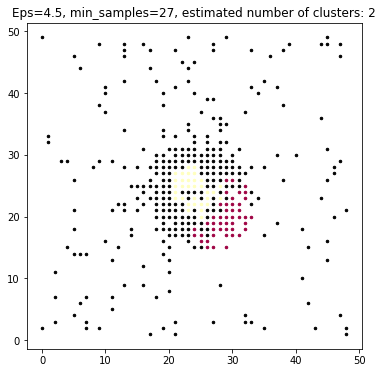

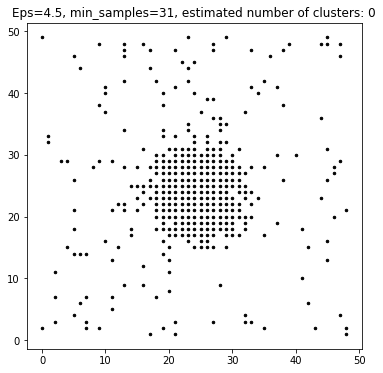

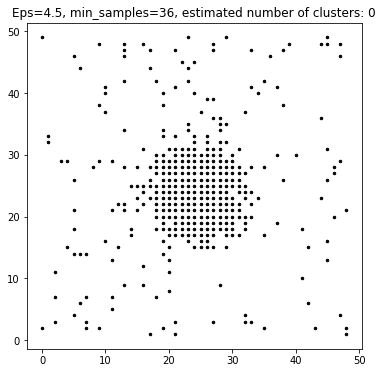

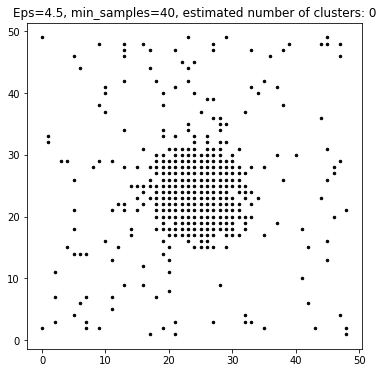

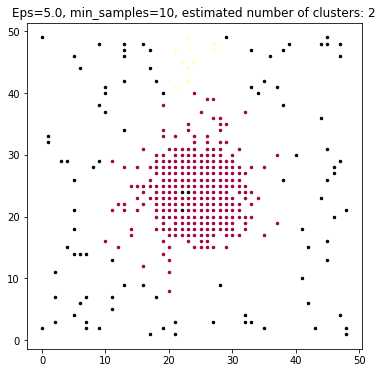

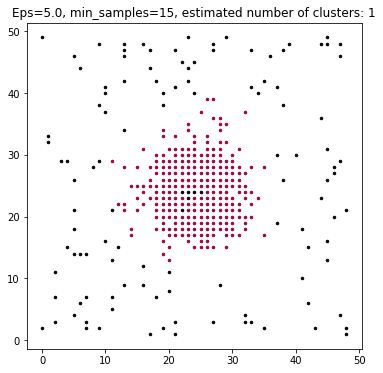

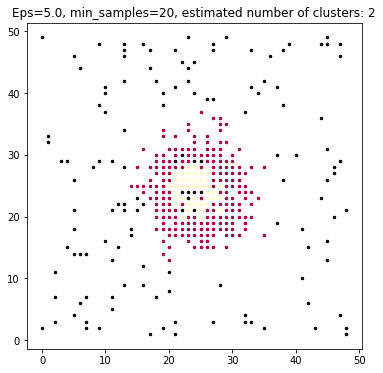

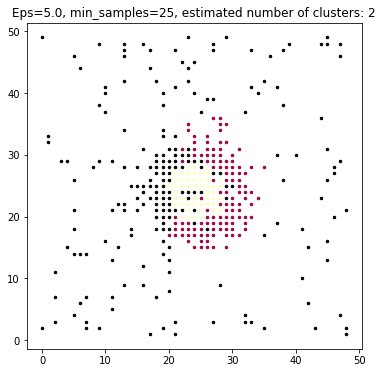

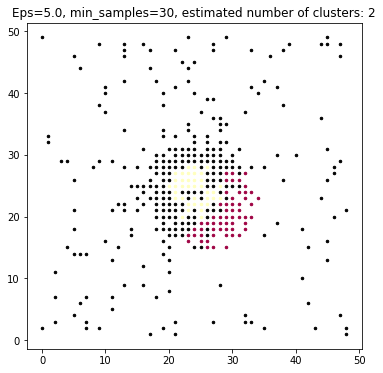

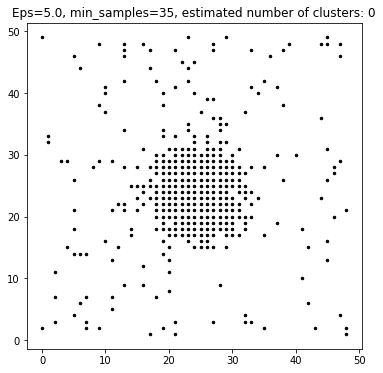

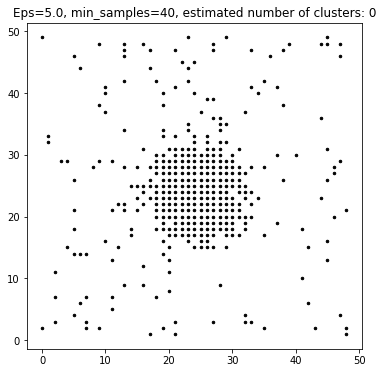

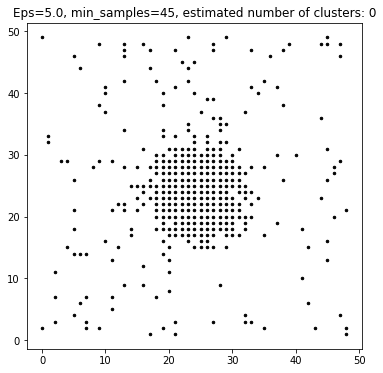

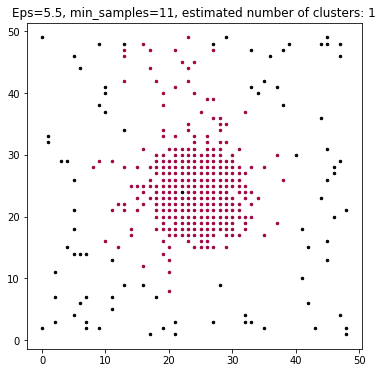

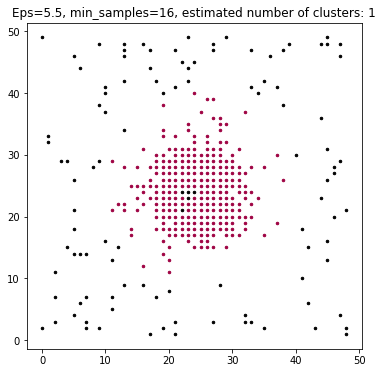

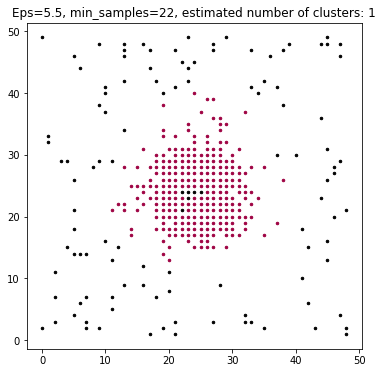

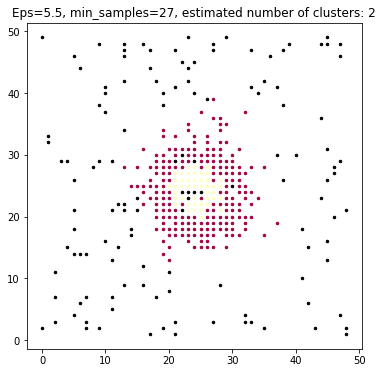

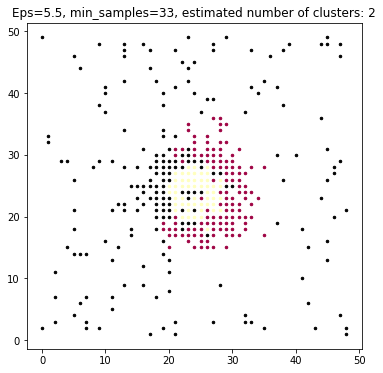

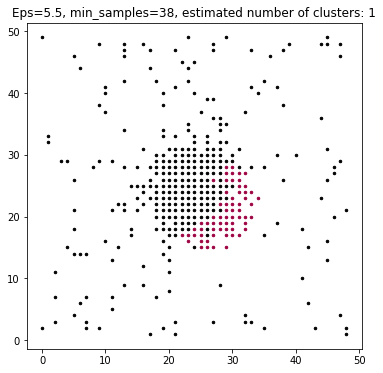

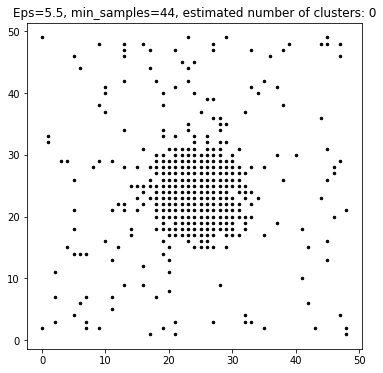

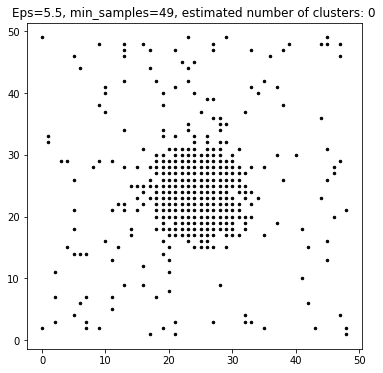

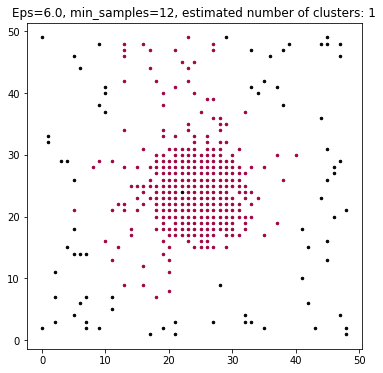

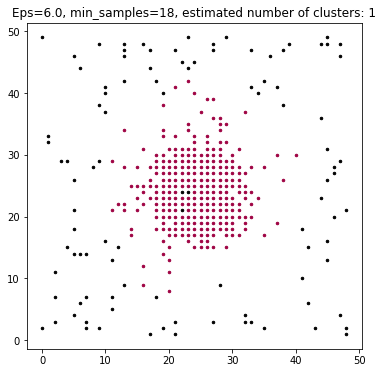

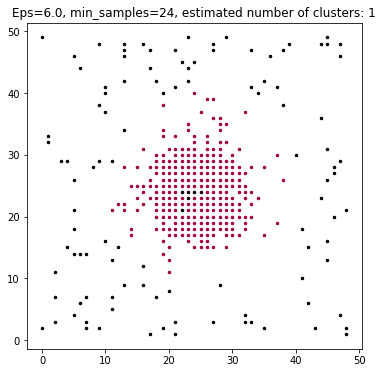

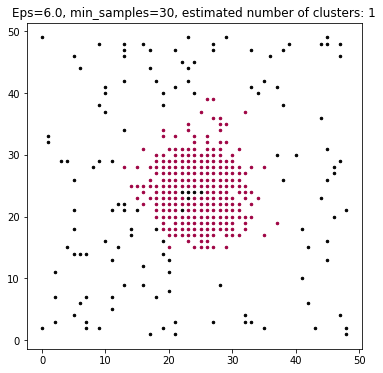

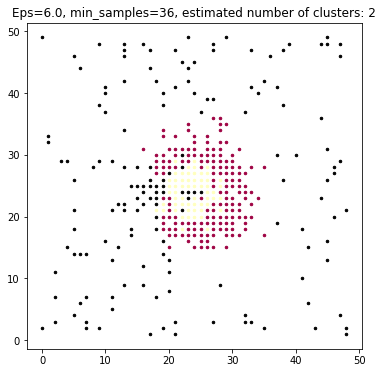

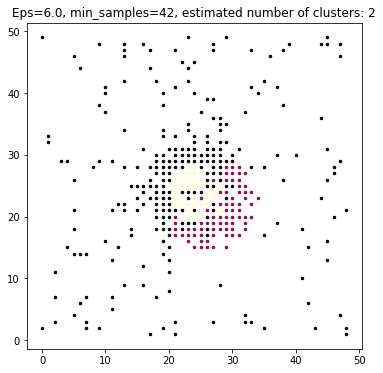

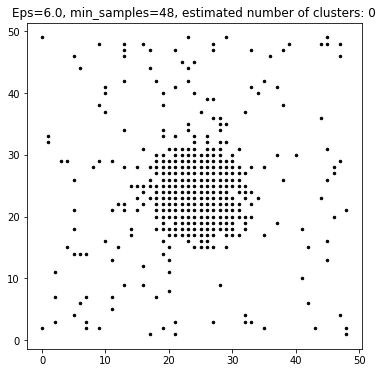

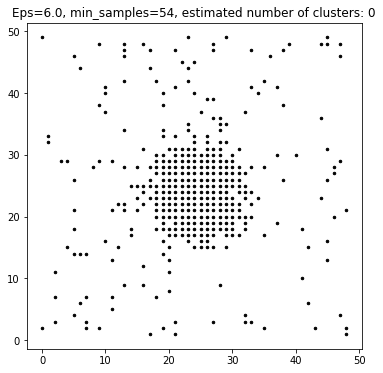

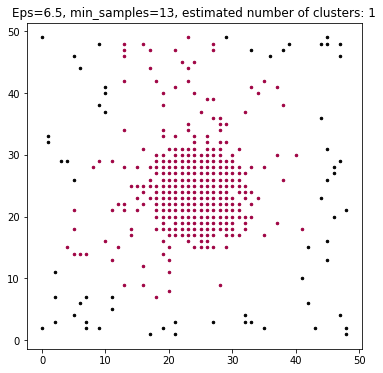

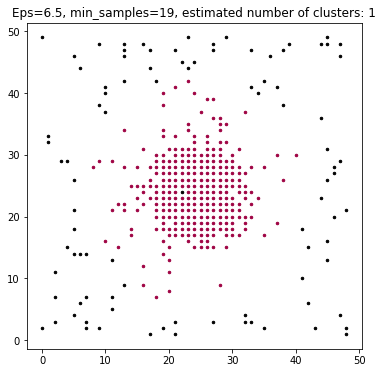

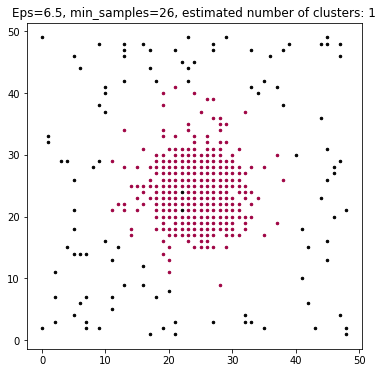

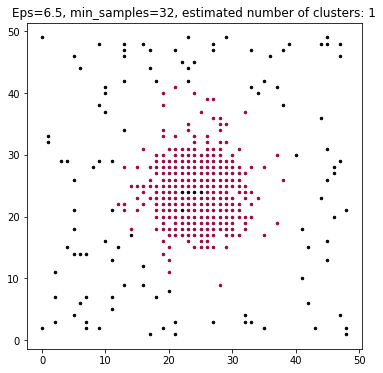

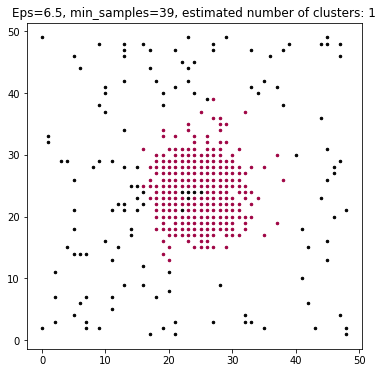

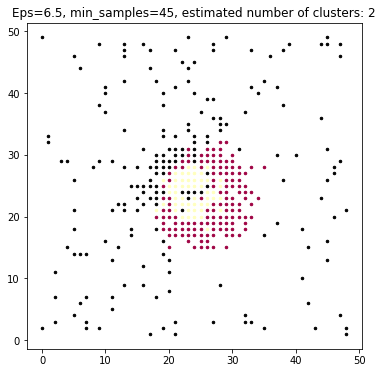

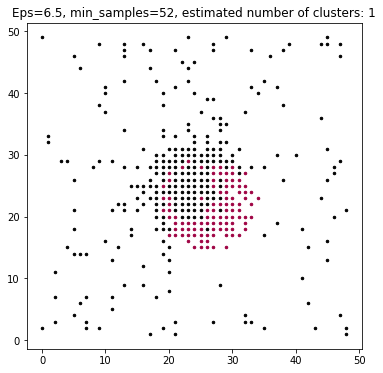

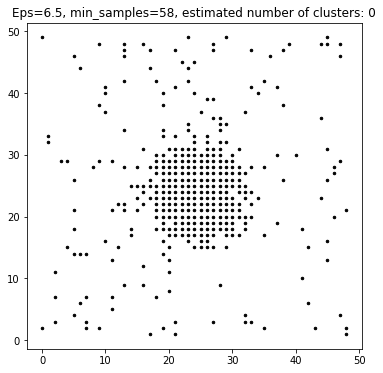

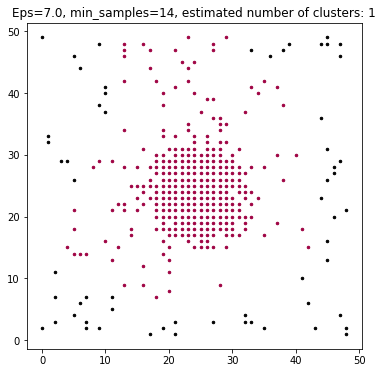

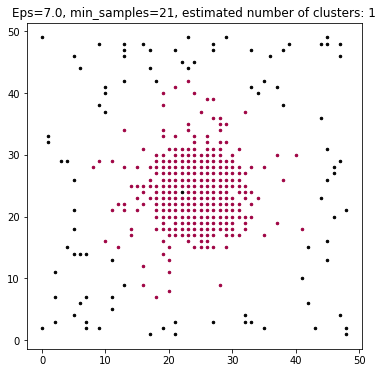

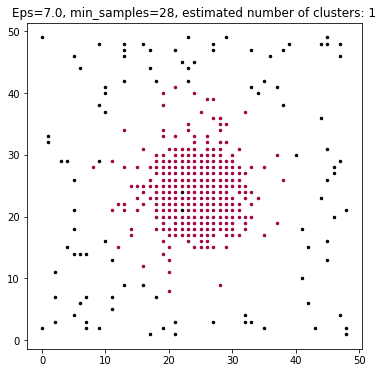

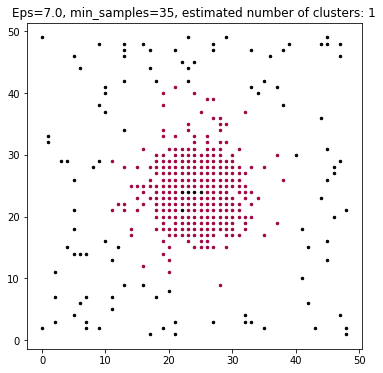

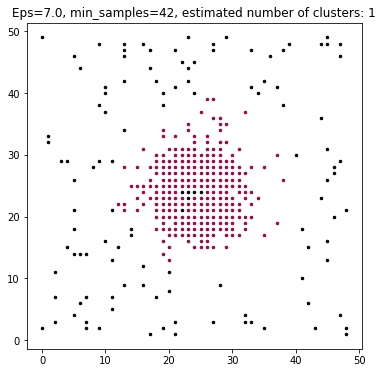

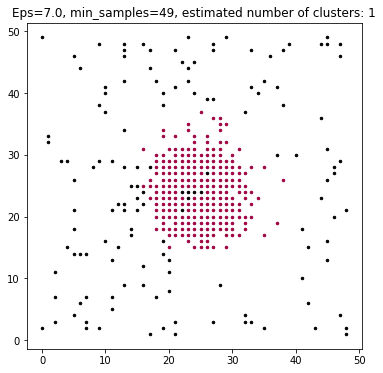

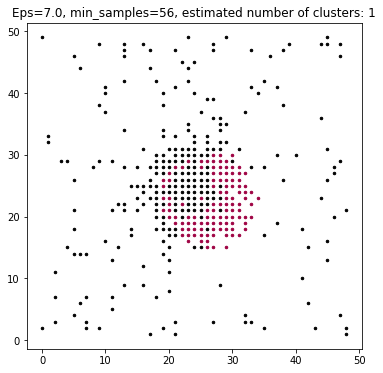

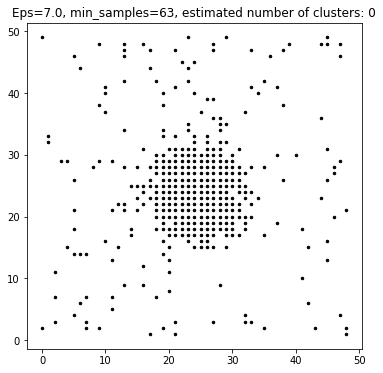

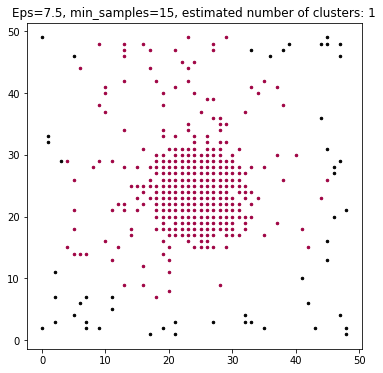

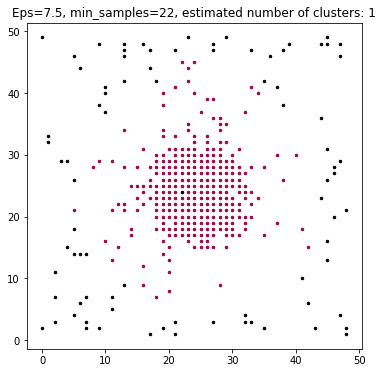

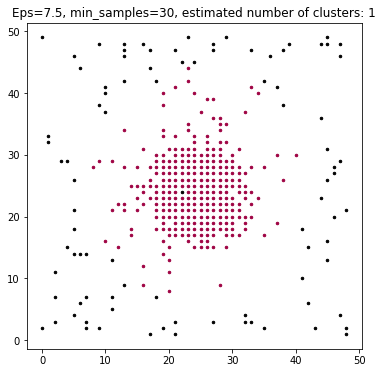

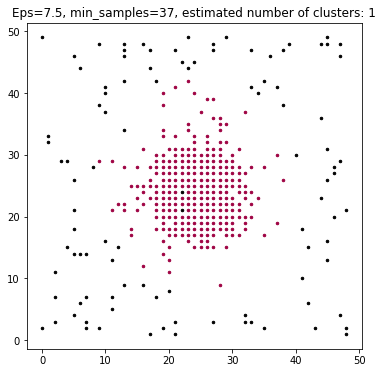

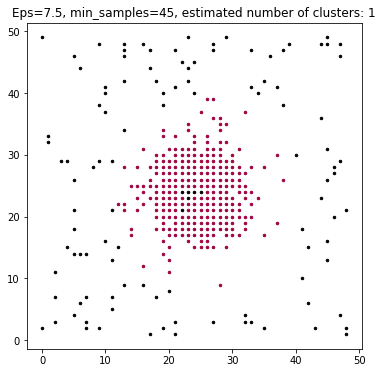

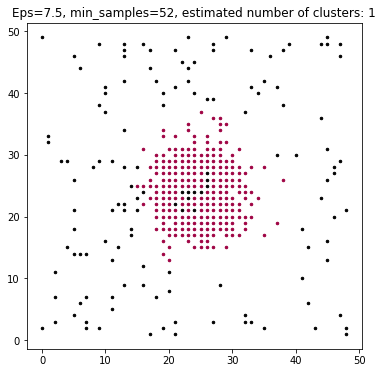

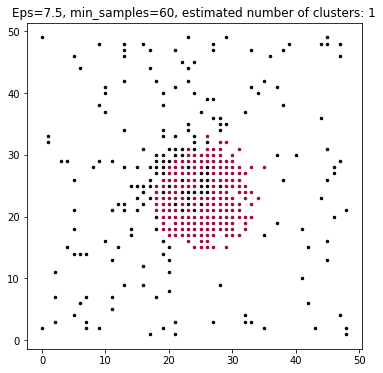

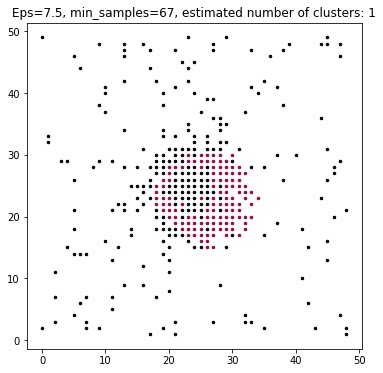

In [88]:
info_cluster=0                #if !=0 print numero di cluster individuati, numero di punti rumore, parametri l'efficienza
plot_cluster=1                #if !=0 plot dei cluster individuati
plot_2d=0                     #if !=0 plot di eff vs min_samples per ogni eps
print_eff=0                   #if !=0 print efficienza per ogni run

eps_range = []
min_samples_range = []
efficiency_best = []

for eps in np.arange(min_eps, max_eps, step_eps):

    min_min_samples = 2*eps
    max_min_samples = 10*eps
    step_min_samples = eps

    for min_samples in np.arange(min_min_samples, max_min_samples, step_min_samples):

        # CLUSTERING

        eps_range.append(eps)
        min_samples_range.append(min_samples)

        db = DBSCAN(eps, min_samples).fit(points)
        core_samples_mask = np.zeros_like(db.labels_,dtype=bool)       # Inizializza un array booleano, della stessa forma di labels_
        core_samples_mask[db.core_sample_indices_] = True              # Considera tutti i core trovati da dbscan
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)    # Conta i cluster, togliendo il  rumore (k=-1)
        n_noise_ = list(labels).count(-1)                              # Numero di punti di rumore

        if info_cluster != 0:

          print('Estimated number of clusters: %d' % n_clusters_)
          print('Estimated number of noise points: %d' % n_noise_)

        mean_dist = []
        members = []

        # Plot dei cluster individuati

        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
        for each in np.linspace(0, 1, len(unique_labels))]             # Sceglie la palette di   colori senza il nero

        efficiency = 0
        weight_sum = 0

        for k, col in zip(unique_labels, colors):                      # Per ogni cluster, associo un colore
        
            class_member_mask = (labels == k)                          # Seleziona tutti i punti del cluster k

            xy_core = points[class_member_mask & core_samples_mask]    # Solo se è nel cluster E è un core point
            xy_border = points[class_member_mask & ~core_samples_mask] # Solo se è nel cluster E non è core  ==  è un edge point del cluster
            
            # Efficienza della clusterizzazione

            phot = 0
            x = 0
            y = 0

            if k == -1:

              col = [0, 0, 0, 1]                          # Nero per il rumore

            else:

              for i in np.arange(0,len(xy_core),1):       # Somme sui pixel contenuti nel cluster k, pesate con il numero di fotoni
                
                x += xy_core[i][0] * xy_core[i][2]
                y += xy_core[i][1] * xy_core[i][2]
                phot += xy_core[i][2]

              for i in np.arange(0,len(xy_border),1):
                
                x += xy_border[i][0] * xy_border[i][2]
                y += xy_border[i][1] * xy_border[i][2]
                phot += xy_border[i][2]

              x /= phot
              y /= phot

              dist = np.sqrt((x-centers[0][0])**2+(y-centers[0][1])**2)
              eff_partial = ((tot_signal - abs(tot_signal-len(xy_core)-len(xy_border)) )/tot_signal)*1/dist

              if eff_partial < 0:
                
                efficiency += 0

              else:

                efficiency += eff_partial
              
              weight_sum += 1/dist

            if plot_cluster != 0:

              plt.plot(xy_core[:, 0], xy_core[:, 1], '.',markerfacecolor=tuple(col),
                    markeredgecolor=tuple(col), markersize=5)

              plt.plot(xy_border[:, 0], xy_border[:, 1], '.',markerfacecolor=tuple(col),
                    markeredgecolor=tuple(col), markersize=5)

        if n_clusters_ != 0:

          efficiency /= weight_sum
          
          efficiency_best.append(efficiency)

        else:
          
          efficiency_best.append(0)
          
        if print_eff != 0:
          print('Eps: %.2f Min_samples: %.2f Efficiency: %f Purity: %f False Negatives: %d Efficiency*Purity: %f' %(eps,min_samples,efficiency,purity,false_negatives,efficiency*purity))

        if plot_cluster != 0:

          plt.title('Eps=%.1lf, min_samples=%d, estimated number of clusters: %d' % (eps,min_samples,n_clusters_))
          fig = matplotlib.pyplot.gcf()
          fig.set_size_inches(6,6)
          plt.show()

#print('Threshold: %.2f Eps: %.2f Min_samples: %.2f Best efficiency: %f Best Purity: %f Overall efficiency: %f' %(th,eps_range[index],min_samples_range[index],efficiency_best[index],purity_best[index],max_efficiency))


